In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def update_groundtruth(wl,wr,previous_ground_truth,t):
    #update the ground truth according to the noise and setup matrix
    
    #initialize current ground truth
    current_ground_truth = [0]*3
    r = 20
    #assume the motor works under 4.8V
    max_rate = 100*2*np.pi/60
    #sample noise in angular speed by using the function numpy.random.normal
    #which takes means and covariance as input and sample 1 output
    nwl = np.random.normal(0, 0.05*max_rate,1)[0]
    nwr = np.random.normal(0, 0.05*max_rate,1)[0]
    
    
    #angle update
    current_ground_truth[0] = previous_ground_truth[0] + (wr+nwr)*t*20/(85*(wr+nwr)/(wl+nwl-wr-nwr))
    current_ground_truth[1] = previous_ground_truth[1] + (abs(wl+nwl+wr+nwr)/2 * np.cos(previous_ground_truth[0]) * t * r) *previous_ground_truth[0]
    current_ground_truth[2] = previous_ground_truth[2] + (abs(wl+nwl+wr+nwr)/2 * np.sin(previous_ground_truth[0]) * t * r) *previous_ground_truth[0]
    
    if current_ground_truth[0] >= 2*np.pi:
        current_ground_truth[0] -= 2*np.pi
    
    return current_ground_truth

In [3]:
def time_update(previous_state_mean,previous_state_cov, t, wl, wr):  
    """
    Each state is a 3*1 vector containing theta, x, and y
    Each state covariance matrix is a matrix related to previous matrix and has dimenson of 3*3
    """
    #check if the shape of input previous state mean vector is legal or not
    #assert(np.shape(previous_state_mean) == (1,3))
    #check if the shape of input previous state covariance matrix is leagl or not
    #assert(np.shape(previous_state_cov) == (3,3)) 
        
    ##setup
    
    #radius
    r = 20 
    #initialize new state list
    new_state_mean = [0]*3
    #max rate
    max_rate = 100*2*np.pi/60
    #input noise
    #Since the noise are caused by the two wheels' angular speed, from the datasheet online, the corviance of the 
    #motor is 5%of the max rate
    Q = np.identity(2) * (0.05*max_rate)**2
    
    
    #initialize Ft 3*3
    Ft = [[0 for _ in range(3)] for _ in range(3)]
    #initialize Wt 3*2
    Wt = [[0 for _ in range(2)] for _ in range(3)]
    
    """Time Update"""
    
    #Setup Ft:
    Ft[0][0] = 1
    Ft[1][0] = - abs(wl+wr)/2 * np.sin(previous_state_mean[0]) * t * r
    Ft[1][1] = 1
    Ft[2][0] = abs(wl+wr)/2 * np.cos(previous_state_mean[0]) * t * r
    Ft[2][2] = 1
    
    #Setup Wt
    Wt[0][0] = t
    Wt[0][1] = -t
    Wt[1][0] = 0.5 * np.cos(previous_state_mean[0]) * t * r
    Wt[1][1] = 0.5 * np.cos(previous_state_mean[0]) * t * r
    Wt[2][0] = 0.5 * np.sin(previous_state_mean[0]) * t * r
    Wt[2][1] = 0.5 * np.sin(previous_state_mean[0]) * t * r
    
    #theta, the angle respect to magnetic north
    new_state_mean[0] = previous_state_mean[0]
    #x position and y position update
    new_state_mean[1] = previous_state_mean[1] + Ft[1][0] * previous_state_mean[0]
    new_state_mean[2] = previous_state_mean[2] + Ft[2][0] * previous_state_mean[0]
    
    #covariance update
    Ft = np.array(Ft)
    Wt = np.array(Wt)
    new_state_cov = np.dot(np.dot(Ft,previous_state_cov),np.transpose(Ft)) + np.dot(np.dot(Wt,Q),np.transpose(Wt))
    return new_state_mean, new_state_cov

In [4]:
def generate_observation(state_grd_trh):
    
    """The state ground turht is coming from the updated ground truth, with a size of 3*1"""
    #assert(np.shape(state_grd_trh) == (3,1))
    
    """This function is aiming at generating a matrix describing the EKF matrix using in the observation update as well as"""
    """the observation ground truth which in real time should be received by the sensors and IMU"""
    H = np.zeros((3,3))
    H[2,0] = 1
    y_grd_trh = np.zeros((3,))
    y_grd_trh[0] = state_grd_trh[0]
    x = state_grd_trh[1]
    y = state_grd_trh[2]
    if state_grd_trh[0] == 0:## point at north
        y_grd_trh[1] = 500-y
        y_grd_trh[2] = 750-x
        H[0,2] = -1
        H[1,1] = -1
    elif state_grd_trh[0] == np.pi/2:
        y_grd_trh[1] = 750 - x
        y_grd_trh[2] = y
        H[0,1] = -1
        H[1,2] = 1
    elif state_grd_trh[0] == np.pi:
        y_grd_trh[1] = y
        y_grd_trh[2] = x
        H[0,2] = 1
        H[1,1] = 1
    elif state_grd_trh[0] == np.pi*3/2:
        y_grd_trh[1] = x
        y_grd_trh[2] = 500-y
        H[0,1] = 1
        H[1,2] = -1
    else:
        y_grd_trh = state_grd_trh
        H[0,2] = 1
        H[1,1] = 1
    return y_grd_trh,H    

In [5]:
def obs_update(previous_mean,previous_cov, t, wl, wr,H,y_grd_trh):
    """Observation Update"""
    #setup observation covariance matrix
    #according to the data sheet, the sensor has a total of 48mm standard 
    #deviation according to 3% ranging distance, 15mm voltage drift, and 30mm
    #temperature drift. I will then just use the 3% ranging distance
    #for IMU, the noise is 0.1 degree/sec in rms
    R = np.identity(3) * (0.03*100)**2
    R[2,2] = (0.1*np.pi/180 * t) **2
    
    #derive the kalman gain
    Kt = np.dot(previous_cov,np.transpose(H))
    temp = np.linalg.inv(np.dot(H,Kt) + R)
    Kt = np.dot(Kt,temp)
    
    nxt_mean = previous_mean + np.dot(Kt, (y_grd_trh - np.dot(H,previous_mean)))
    nxt_cov = previous_cov - np.dot(np.dot(Kt,H),previous_cov)
    return nxt_mean,nxt_cov

In [6]:
def state_estimator(previous_grd_trh, previous_state,previous_covariance,wl,wr,t):
    new_grd_truth = update_groundtruth(wl,wr,previous_grd_trh,t)
    new_mean, new_cov = time_update(previous_state,previous_covariance,t,wl,wr)
    y_grd_trh, H = generate_observation(new_grd_truth)
    new_mean, new_cov = obs_update(new_mean,new_cov,t,wl,wr,H,y_grd_trh)
    return y_grd_trh, new_mean, new_cov

In [7]:
"""
if initial state is known
"""
y = []
mean = []
cov = []
for i in range(100):
    t = i/100
    if i == 0:
        y_grd_trh,new_mean,new_cov = state_estimator([np.pi*1/2,0,250],[np.pi*1/2,0,250],np.array([[0.1,0,0],[0,0.1,0],[0,0.1,1]]),1,1,t)
        y.append(y_grd_trh)
        mean.append(new_mean)
        cov.append(new_cov)
    else:
        y_grd_trh,new_mean,new_cov = state_estimator(y_grd_trh,new_mean,new_cov,1,1,t)
        y.append(y_grd_trh)
        mean.append(new_mean)
        cov.append(new_cov)
        

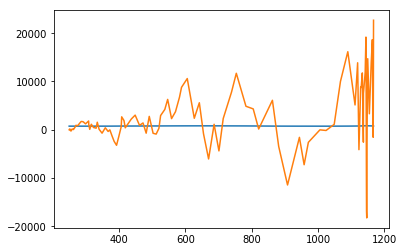

In [8]:
plt.plot(np.array(y)[:,2],np.array(y)[:,1])
plt.plot(np.array(mean)[:,0],np.array(mean)[:,1])
plt.show()

In [23]:
"""
if initial state is unknown
"""
y = []
mean = []
cov = []
for i in range(100):
    t = i/100
    if i == 0:
        y_grd_trh,new_mean,new_cov = state_estimator([np.pi*1/2,750/2,250],[np.pi*1/2,750/2,250],np.array([[1000,0,0],[0,1000,0],[0,0,1000]]),1,1,t)
        y.append(y_grd_trh)
        mean.append(new_mean)
        cov.append(new_cov)
    else:
        y_grd_trh,new_mean,new_cov = state_estimator(y_grd_trh,new_mean,new_cov,1,1,t)
        y.append(y_grd_trh)
        mean.append(new_mean)
        cov.append(new_cov)
        

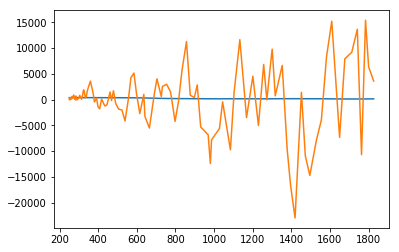

In [24]:
plt.plot(np.flip(np.array(y)[:,2],0),np.flip(np.array(y)[:,1],0))
plt.plot(np.flip(np.array(mean)[:,0],0),np.flip(np.array(mean)[:,1],0))
plt.show()